https://rajmak.wordpress.com/2017/12/07/text-classification-classifying-product-titles-using-convolutional-neural-network-and-word2vec-embedding/

In [31]:
import pickle
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.base import get_data_home
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gensim

In [32]:
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300

In [33]:
category_mapping = {
    'Singapore': 1,
    'Sports': 2,
    'Lifestyle': 3,
    'World': 4,
    'Business': 5,
    'Technology': 6
}

In [34]:
#Processed Data Frame [ Do Not Use this, Use the Training, Tesing and Validation Data Sets Instead]
data_path = "./Pickles/all_articles_processed.pickle"
with open(data_path, 'rb') as data:
    df = pickle.load(data)

In [35]:
df['category'].value_counts()
df=df.sample(frac=1)

In [36]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 5040
Test size: 2160


In [37]:
df['category'].unique()

array(['World', 'Singapore', 'Business', 'Sports', 'Technology',
       'Lifestyle'], dtype=object)

In [38]:
train_posts = df['article'][:train_size]
train_tags = df['category'][:train_size]

test_posts = df['article'][train_size:]
test_tags = df['category'][train_size:]

In [39]:
max_words = 1000
tokenize = text.Tokenizer(num_words=MAX_NB_WORDS, char_level=False)

In [40]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [41]:
x_train = tokenize.texts_to_sequences(train_posts)
x_test = tokenize.texts_to_sequences(test_posts)

x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

In [42]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [43]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [44]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5040, 30)
x_test shape: (2160, 30)
y_train shape: (5040, 6)
y_test shape: (2160, 6)


In [45]:
from gensim.models import Word2Vec
word2vec= gensim.models.KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz", binary=True)
word2vec .init_sims(replace=True)

C:\Users\User\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [46]:
print('Found %s word vectors of word2vec' % len(word2vec .vocab))

Found 3000000 word vectors of word2vec


In [47]:
vocab_size = len(tokenize.word_index) 
print('Found %s word vectors of word2vec' % vocab_size)

Found 60102 word vectors of word2vec


In [48]:
from tensorflow.keras.layers import Embedding
word_index = tokenize.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Null word embeddings: 30297


In [49]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.4959235965525274

In [50]:
def createModel():# Build the model
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Conv1D(300, 3, padding='valid',activation='relu',strides=2))
    model.add(Conv1D(150, 3, padding='valid',activation='relu',strides=2))
    model.add(Conv1D(75, 3, padding='valid',activation='relu',strides=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(150,activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [51]:
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           18030900  
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 14, 300)           270300    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 150)            135150    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 75)             33825     
_________________________________________________________________
flatten_2 (Flatten)          (None, 150)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
__________

In [52]:
modelname   = 'w2v_cnn'
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [53]:
model.fit(x_train, 
          y_train, 
          validation_data=(x_test, y_test), 
          epochs=100, 
          batch_size=128,
          shuffle=True,
          callbacks=callbacks_list)

Train on 5040 samples, validate on 2160 samples
Epoch 1/100
5040/5040 [==============================] - 6s 1ms/sample - loss: 0.4791 - acc: 0.8154 - val_loss: 0.4338 - val_acc: 0.8333
Epoch 2/100
5040/5040 [==============================] - 4s 805us/sample - loss: 0.4157 - acc: 0.8356 - val_loss: 0.3711 - val_acc: 0.8485
Epoch 3/100
5040/5040 [==============================] - 4s 801us/sample - loss: 0.3501 - acc: 0.8567 - val_loss: 0.3307 - val_acc: 0.8609
Epoch 4/100
5040/5040 [==============================] - 4s 808us/sample - loss: 0.3132 - acc: 0.8662 - val_loss: 0.3020 - val_acc: 0.8696
Epoch 5/100
5040/5040 [==============================] - 4s 814us/sample - loss: 0.2877 - acc: 0.8738 - val_loss: 0.3010 - val_acc: 0.8725
Epoch 6/100
5040/5040 [==============================] - 4s 825us/sample - loss: 0.2729 - acc: 0.8802 - val_loss: 0.3052 - val_acc: 0.8736
Epoch 7/100
5040/5040 [==============================] - 4s 814us/sample - loss: 0.2553 - acc: 0.8918 - val_loss: 0.2951

5040/5040 [==============================] - 4s 735us/sample - loss: 0.0182 - acc: 0.9917 - val_loss: 0.6077 - val_acc: 0.8595
Epoch 60/100
5040/5040 [==============================] - 4s 740us/sample - loss: 0.0181 - acc: 0.9923 - val_loss: 0.5997 - val_acc: 0.8641
Epoch 61/100
5040/5040 [==============================] - 4s 746us/sample - loss: 0.0185 - acc: 0.9914 - val_loss: 0.6000 - val_acc: 0.8644
Epoch 62/100
5040/5040 [==============================] - 4s 736us/sample - loss: 0.0180 - acc: 0.9919 - val_loss: 0.6078 - val_acc: 0.8619
Epoch 63/100
5040/5040 [==============================] - 4s 740us/sample - loss: 0.0176 - acc: 0.9919 - val_loss: 0.6094 - val_acc: 0.8647
Epoch 64/100
5040/5040 [==============================] - 4s 747us/sample - loss: 0.0173 - acc: 0.9923 - val_loss: 0.6198 - val_acc: 0.8635
Epoch 65/100
5040/5040 [==============================] - 4s 740us/sample - loss: 0.0181 - acc: 0.9915 - val_loss: 0.6395 - val_acc: 0.8626
Epoch 66/100
5040/5040 [=========

In [54]:
optmz       = optimizers.RMSprop(lr=0.0001)

In [55]:
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

In [56]:
# Make classification on the test dataset
predicts    = modelGo.predict(x_test)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

# the labels for the classfication report
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)

In [57]:
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=category_mapping,digits=4))
print(confusion)

Best accuracy (on testing dataset): 60.56%
              precision    recall  f1-score   support

   Singapore     0.5503    0.4339    0.4852       378
      Sports     0.6295    0.7345    0.6780       354
   Lifestyle     0.5342    0.5285    0.5313       369
       World     0.9110    0.8273    0.8672       359
    Business     0.5297    0.5791    0.5533       354
  Technology     0.5040    0.5405    0.5216       346

    accuracy                         0.6056      2160
   macro avg     0.6098    0.6073    0.6061      2160
weighted avg     0.6097    0.6056    0.6052      2160

[[164  20  40   3 102  49]
 [  3 260  35   9  15  32]
 [ 25  46 195   6  34  63]
 [  0  28  10 297  10  14]
 [ 58  30  31   4 205  26]
 [ 48  29  54   7  21 187]]


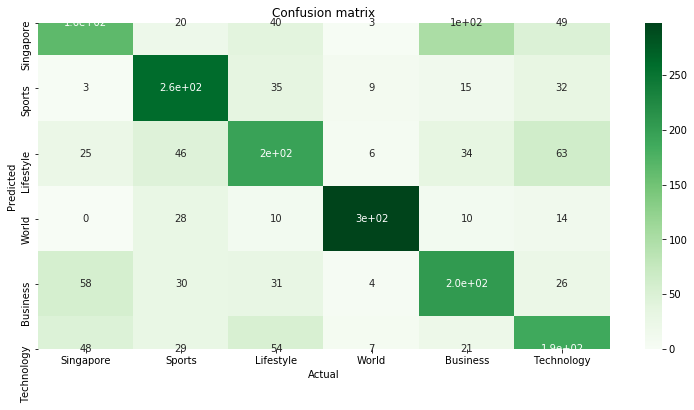

In [58]:
conf_matrix = confusion_matrix(testout, predout)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=category_mapping, 
            yticklabels=category_mapping,
            cmap="Greens")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()